In [29]:
from collections import OrderedDict, ChainMap
import numpy as np
import pandas as pd
import tellurium as te
import graphviz
import matplotlib.pyplot as plt
te.setDefaultPlottingEngine('matplotlib')
% matplotlib inline

In [13]:
r = te.loada('''
    v1=1; v2=1; v3=1; v4=1; v5=1; v6=1;
    J1: -> S1; v1;
    J2: S1 -> S2; v2;
    J3: S2 -> ; v3;
    J4: S3 -> S1; v4;
    J5: S3 -> S2; v5;
    J6: -> S3; v6;
''')
r.J3

1.0

In [24]:
components = OrderedDict({
    'resources': {'type': 'state', 'value': 100000.0, 'lower_bound': 0.0, 'upper_bound': 100000.0},
    'growth': {'type': 'state', 'value': 0.0, 'lower_bound': 0.0, 'upper_bound': 1000.0},
    'light460nm': {'type': 'stimulus', 'value': 0.0, 'lower_bound': 0.0, 'upper_bound': 1000.0},
    'gene_nMag_T7RNAPn': {'type': 'gene', 'value': True},
    'gene_pMag_T7RNAPc': {'type': 'gene', 'value': True},
    'gene_pT7_CAR': {'type': 'gene', 'value': True},
    'prot_nMag_T7RNAPn': {'type': 'protein', 'value': 0.0, 'lower_bound': 0.0, 'upper_bound': 1000.0},
    'prot_pMag_T7RNAPc': {'type': 'protein', 'value': 0.0, 'lower_bound': 0.0, 'upper_bound': 1000.0},
    'prot_Mag_T7RNAP': {'type': 'protein', 'value': 0.0, 'lower_bound': 0.0, 'upper_bound': 1000.0},
    'prot_CAR': {'type': 'protein', 'value': 0.0, 'lower_bound': 0.0, 'upper_bound': 1000.0},
    'prot_CAR_bound': {'type': 'protein', 'value': 0.0, 'lower_bound': 0.0, 'upper_bound': 10.0},
})

In [36]:
reactions = OrderedDict({
    'constitutive nMag_T7RNAPn expression': {
        'reactants': {'resources': -1.0},
        'products': {'prot_nMag_T7RNAPn': 1.0},
        'rate': 1.0,
        'modifiers': None
    },
    'constitutive pMag_T7RNAPc expression': {
        'reactants': {'resources': -1.0},
        'products': {'prot_pMag_T7RNAPc': 1.0},
        'rate': 1.0,
        'modifiers': None
    },
    'light induced nMag-pMag dimerization': {
        'reactants': {'prot_nMag_T7RNAPn': -1.0, 'prot_pMag_T7RNAPc': -1.0},
        'products': {'prot_Mag_T7RNAP': 1.0},
        'rate': 1.0,
        'modifiers': {'light460nm': 'activator'}
    },
    'T7RNAP driven CAR expression': {
        'reactants': {'resources': -1.0},
        'products': {'prot_CAR': 1.0},
        'rate': 1.0,
        'modifiers': {'prot_Mag_T7RNAP': 'activator'}
    },
    'T-cell exhaustion': {
        'reactants': {'prot_CAR': -1.0, 'resources': -1.0},
        'products': {},
        'rate': 1.0,
        'modifiers': {'prot_CAR_bound': 'activator'}
    },
    'T-cell proliferation': {
        'reactants': {'resources': -1.0},
        'products': {'growth': 1.0},
        'rate': 1.0,
        'modifiers': None
    },
    'metabolism': {
        'reactants': {},
        'products': {'resources': 10.0},
        'rate': 1.0,
        'modifiers': None
    },
})

In [37]:
pd.DataFrame(components)

,resources,growth,light460nm,gene_nMag_T7RNAPn,gene_pMag_T7RNAPc,gene_pT7_CAR,prot_nMag_T7RNAPn,prot_pMag_T7RNAPc,prot_Mag_T7RNAP,prot_CAR,prot_CAR_bound
lower_bound,0,0,0,NaN,NaN,NaN,0,0,0,0,0
type,state,state,stimulus,gene,gene,gene,protein,protein,protein,protein,protein
upper_bound,100000,1000,1000,NaN,NaN,NaN,1000,1000,1000,1000,10
value,100000,0,0,True,True,True,0,0,0,0,0


In [38]:
pd.DataFrame(reactions)

,constitutive nMag_T7RNAPn expression,constitutive pMag_T7RNAPc expression,light induced nMag-pMag dimerization,T7RNAP driven CAR expression,T-cell exhaustion,T-cell proliferation,metabolism
modifiers,None,None,{'light460nm': 'activator'},{'prot_Mag_T7RNAP': 'activator'},{'prot_CAR_bound': 'activator'},None,None
products,{'prot_nMag_T7RNAPn': 1.0},{'prot_pMag_T7RNAPc': 1.0},{'prot_Mag_T7RNAP': 1.0},{'prot_CAR': 1.0},{},{'growth': 1.0},{'resources': 10.0}
rate,1,1,1,1,1,1,1
reactants,{'resources': -1.0},{'resources': -1.0},"{'prot_nMag_T7RNAPn': -1.0, 'prot_pMag_T7RNAPc...",{'resources': -1.0},"{'prot_CAR': -1.0, 'resources': -1.0}",{'resources': -1.0},{}


In [28]:
list(components.keys()).index('prot_CAR')

9

In [53]:
def get_matcell(components, reactions):
    rinfos = list(reactions.values())
    for n, r in enumerate(reactions):
        stoichs = ChainMap(rinfos[n]['reactants'], rinfos[n]['products'])
        print(stoichs)
        if n == 0:
            print(list(components.keys()))
            print(list(stoichs.keys()))
            m = [list(components.keys()).index(key) for key in list(stoichs.keys())]
            print(m)
#             print(list(stoichs.values()))
        
get_matcell(components, reactions)

ChainMap({'resources': -1.0}, {'prot_nMag_T7RNAPn': 1.0})
['resources', 'growth', 'light460nm', 'gene_nMag_T7RNAPn', 'gene_pMag_T7RNAPc', 'gene_pT7_CAR', 'prot_nMag_T7RNAPn', 'prot_pMag_T7RNAPc', 'prot_Mag_T7RNAP', 'prot_CAR', 'prot_CAR_bound']
['prot_nMag_T7RNAPn', 'resources']
[6, 0]
ChainMap({'resources': -1.0}, {'prot_pMag_T7RNAPc': 1.0})
ChainMap({'prot_nMag_T7RNAPn': -1.0, 'prot_pMag_T7RNAPc': -1.0}, {'prot_Mag_T7RNAP': 1.0})
ChainMap({'resources': -1.0}, {'prot_CAR': 1.0})
ChainMap({'prot_CAR': -1.0, 'resources': -1.0}, {})
ChainMap({'resources': -1.0}, {'growth': 1.0})
ChainMap({}, {'resources': 10.0})


In [23]:
for rinfo in reactions.values():
    component_names = rinfo['reactants']
    col = list(components.keys()).index(component_name)

{'reactants': {'resources': -1.0}, 'products': {'prot_nMag_T7RNAPn': 1.0}, 'rate': 1.0, 'modifiers': None}
{'reactants': {'resources': -1.0}, 'products': {'prot_pMag_T7RNAPc': 1.0}, 'rate': 1.0, 'modifiers': None}
{'reactants': {'prot_nMag_T7RNAPn': -1.0, 'prot_pMag_T7RNAPc': -1.0}, 'products': {'prot_Mag_T7RNAP': 1.0}, 'rate': 1.0, 'modifiers': {'light460nm': 'activator'}}
{'reactants': {'resources': -1.0}, 'products': {'prot_CAR': 1.0}, 'rate': 1.0, 'modifiers': {'prot_Mag_T7RNAP': 'activator'}}
{'reactants': {'prot_CAR': -1.0, 'resources': -1.0}, 'products': None, 'rate': 1.0, 'modifiers': {'prot_CAR_bound': 'activator'}}
{'reactants': {'resources': -1.0}, 'products': {'growth': 1.0}, 'rate': 1.0, 'modifiers': None}
{'reactants': None, 'products': {'resources': 10.0}, 'rate': 1.0, 'modifiers': None}


In [16]:
S_matrix = np.zeros((5, 5))
S_matrix

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [18]:
S_matrix[2, 3] = 1.0
S_matrix

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [47]:
S_matrix = np.array([
    [-1.0, -1.0, 0.0, -1.0, -1.0, -1.0, 10.0],
    [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
    [1.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 1.0, -1.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0],
    [0.0, 0.0, 0.0, 1.0, -1.0, 0.0, 0.0],
])

In [48]:
v_vector = np.array([rxn['rate'] for rxn in reactions.values()])

In [49]:
v_vector

array([1., 1., 1., 1., 1., 1., 1.])

In [53]:
c_vector = np.array([100000.0, 0.0, 0.0, 0.0, 0.0, 0.0])

In [56]:
c_vector = c_vector + np.matmul(S_matrix, v_vector)

In [57]:
c_vector

array([1.0001e+05, 2.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00,
       0.0000e+00])

In [4]:
class SubCellularNetwork(object):
    """Dynamics of subcellular components - genes, proteins, etc."""
    
    def __init__(self):
        self.components = {}
        self.reactions = {}
        
    def add_components(self, components):
        self.components.update(components)
    
    def remove_components(self, components):
        [self.components.pop(component, None) for component in components]
        
    def add_reactions(self, reactions):
        self.reactions.update(reactions)
    
    def remove_reactions(self, reactions):
        [self.reactions.pop(reaction, None) for reaction in reactions]
        
    def update_stoich_matrix(self):
        for reaction in self.reactions.values():
            

    def react(self, reactants, products, modifiers):
        polarity_mapping = {'activator': 1.0, 'inhibitor': -1.0}
        rate_modifier = 1.0
        if modifiers:
            for modifier, polarity in modifiers.items():
                if type(self.components[modifier]['value']) == bool:
                    rate_modifier = float(self.components[modifier]['value'])
                else:
                    rate_modifier = polarity_mapping[polarity] * 2*np.tanh(self.components[modifier]['value'])
        if reactants:
            for reactant_name, reactant_rate in reactants.items():
                change = reactant_rate * rate_modifier
                current = self.components[reactant_name]['value']
                upper = self.components[reactant_name]['upper_bound']
                lower = self.components[reactant_name]['lower_bound']
                if lower < current + change < upper:
                    self.components[reactant_name]['value'] += change
        if products:
            for product_name, product_rate in products.items():
                change = product_rate * rate_modifier
                current = self.components[product_name]['value']
                upper = self.components[product_name]['upper_bound']
                lower = self.components[product_name]['lower_bound']
                if lower < current + change < upper:
                    self.components[product_name]['value'] += change
                    
    
            
    def update(self):
        [self.react(rxn['reactants'], rxn['products'], rxn['modifiers']) for rxn in self.reactions.values()]

In [5]:
scn = SubCellularNetwork()

In [6]:
scn.add_components(components)

In [7]:
scn.components

{'gene_nMag_T7RNAPn': {'type': 'gene', 'value': True},
 'gene_pMag_T7RNAPc': {'type': 'gene', 'value': True},
 'gene_pT7_CAR': {'type': 'gene', 'value': True},
 'growth': {'lower_bound': 0.0,
  'type': 'state',
  'upper_bound': 1000.0,
  'value': 0.0},
 'light460nm': {'lower_bound': 0.0,
  'type': 'stimulus',
  'upper_bound': 1000.0,
  'value': 0.0},
 'prot_CAR': {'lower_bound': 0.0,
  'type': 'protein',
  'upper_bound': 1000.0,
  'value': 0.0},
 'prot_CAR_bound': {'lower_bound': 0.0,
  'type': 'protein',
  'upper_bound': 10.0,
  'value': 0.0},
 'prot_Mag_T7RNAP': {'lower_bound': 0.0,
  'type': 'protein',
  'upper_bound': 1000.0,
  'value': 0.0},
 'prot_nMag_T7RNAPn': {'lower_bound': 0.0,
  'type': 'protein',
  'upper_bound': 1000.0,
  'value': 0.0},
 'prot_pMag_T7RNAPc': {'lower_bound': 0.0,
  'type': 'protein',
  'upper_bound': 1000.0,
  'value': 0.0},
 'resources': {'lower_bound': 0.0,
  'type': 'state',
  'upper_bound': 100000.0,
  'value': 100000.0}}

In [8]:
scn.add_reactions(reactions)

In [9]:
scn.reactions

{'T-cell exhaustion': {'modifiers': {'prot_CAR_bound': 'activator'},
  'products': None,
  'reactants': {'prot_CAR': -1.0, 'resources': -1.0}},
 'T-cell proliferation': {'modifiers': None,
  'products': {'growth': 1.0},
  'reactants': {'resources': -1.0}},
 'T7RNAP driven CAR expression': {'modifiers': {'prot_Mag_T7RNAP': 'activator'},
  'products': {'prot_CAR': 1.0},
  'reactants': {'resources': -1.0}},
 'constitutive nMag_T7RNAPn expression': {'modifiers': None,
  'products': {'prot_nMag_T7RNAPn': 1.0},
  'reactants': {'resources': -1.0}},
 'constitutive pMag_T7RNAPc expression': {'modifiers': None,
  'products': {'prot_pMag_T7RNAPc': 1.0},
  'reactants': {'resources': -1.0}},
 'light induced nMag-pMag dimerization': {'modifiers': {'light460nm': 'activator'},
  'products': {'prot_Mag_T7RNAP': 1.0},
  'reactants': {'prot_nMag_T7RNAPn': -1.0, 'prot_pMag_T7RNAPc': -1.0}},
 'metabolism': {'modifiers': None,
  'products': {'resources': 10.0},
  'reactants': None}}

In [10]:
car = []
nmag_t7rnap = []
for i in range(100):
    scn.components['light460nm']['value'] += 1.0
    scn.update()
    car.append(scn.components['prot_CAR']['value'])
    nmag_t7rnap.append(scn.components['prot_nMag_T7RNAPn']['value'])

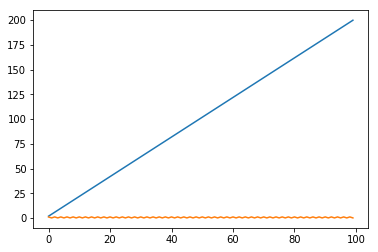

In [11]:
plt.plot(np.array(car))
plt.plot(np.array(nmag_t7rnap))

In [12]:
scn.components

{'gene_nMag_T7RNAPn': {'type': 'gene', 'value': True},
 'gene_pMag_T7RNAPc': {'type': 'gene', 'value': True},
 'gene_pT7_CAR': {'type': 'gene', 'value': True},
 'growth': {'lower_bound': 0.0,
  'type': 'state',
  'upper_bound': 1000.0,
  'value': 100.0},
 'light460nm': {'lower_bound': 0.0,
  'type': 'stimulus',
  'upper_bound': 1000.0,
  'value': 100.0},
 'prot_CAR': {'lower_bound': 0.0,
  'type': 'protein',
  'upper_bound': 1000.0,
  'value': 199.81440973252396},
 'prot_CAR_bound': {'lower_bound': 0.0,
  'type': 'protein',
  'upper_bound': 10.0,
  'value': 0.0},
 'prot_Mag_T7RNAP': {'lower_bound': 0.0,
  'type': 'protein',
  'upper_bound': 1000.0,
  'value': 199.43980156403381},
 'prot_nMag_T7RNAPn': {'lower_bound': 0.0,
  'type': 'protein',
  'upper_bound': 1000.0,
  'value': 0.07331127560772632},
 'prot_pMag_T7RNAPc': {'lower_bound': 0.0,
  'type': 'protein',
  'upper_bound': 1000.0,
  'value': 0.07331127560772632},
 'resources': {'lower_bound': 0.0,
  'type': 'state',
  'upper_boun

In [13]:
# Need upper and lower bounds for components